In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import numba as nb
from IPython.display import Markdown, display

In [2]:
# Hooks again but quite different to the previous ones.
# 19 regions each which must add up to 15
# same approch as hooks #5 &#6
# -run through the hook placements to see which are allowed
# -for each hook placement check the ones that are forced by 
#  the constraints
# -solve the final cells with backtracking
# using old code from hooks #6 but adding in some numba speed ups to the checks.
# starting top right and looping cols then rows is much faster than starting top left
# and looping rows then cols

url='https://www.janestreet.com/puzzles/hooks-7-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[9:12]))))

### Hooks #7

Show Solution
The grid above can be partitioned into 9 L-shaped “hooks”. The largest
is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains
15 squares), and so on. The smallest hook is just a single square.
Find where the hooks are located, and place nine 9’s in the largest
hook, eight 8’s in the next-largest, etc., down to one 1 in the
smallest hook.
The filled squares must form a connected region. (Squares are
“connected” if they are orthogonally adjacent.) Furthermore, every
2-by-2 region must contain at least one unfilled square.

### Puzzle details
<img src="https://www.janestreet.com/puzzles/20210217_hooks_7.png" width="350" height="300">

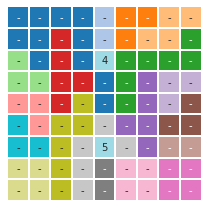

In [3]:
# Setup the constraints
# use 20 for the filled cells and treat as smaller 
# groups with a different total
# then print the grid

groups = np.array([[0 ,0 ,0 ,0 ,1 ,2 ,2 ,3 ,3 ],
                   [0 ,0 ,6 ,0 ,1 ,2 ,3 ,3 ,4 ],
                   [5 ,0 ,6 ,0 ,20,4 ,4 ,4 ,4 ],
                   [5 ,5 ,6 ,6 ,0 ,4 ,8 ,9 ,9 ],
                   [7 ,7 ,6 ,16,0 ,4 ,8 ,9 ,10],
                   [18,7 ,16,16,15,8 ,8 ,10,10],
                   [18,18,16,15,20,15,8 ,11,11],
                   [17,17,16,15,14,13,13,12,12],
                   [17,17,16,15,14,13,13,12,12]                   
                 ])

fixed = np.array([[0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,4,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,5,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0]
                 ])

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=1)
    ax.axis("off")
    plt.tight_layout()
    
grid_print(groups,fixed)

# use -1 to denote unfilled
fixed[fixed==0] =-1

In [10]:
class Matrix():
    def __init__(self,groups):
        self.groups = groups
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.totals =np.array([11,15,15,15,15,15,15,15,15,15,15,15,15,15,15,10,15,15,15],dtype=int)
        self.splits ={}
        self.end_flag = 0
        # work out the possible permutations for each group
        for i in range(19):
            length = np.sum(groups==i)
            self.splits[i] =  np.array([list(i) for i in itertools.product([0, 1], repeat=length)],dtype=int)
     
    #########################################################
    # Code to get the initial valid grids 
    # add layer by layer until it is not possible to create the sum 
    # for every filled group
    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords
    
    def check_grid(self,grid):
        # check the 2 fixed numbers
        if (grid[2,4] !=-1) & (grid[2,4] !=4):
            return False
        if (grid[6,4] != -1) &(grid[6,4] != 5):
            return False
        
        for i in range(19):
            group = grid[groups==i]
            if -1 not in group:
                if not self.check_group(group,self.totals[i],self.splits[i]):
                    return False

        return True
    
    @staticmethod
    @nb.njit(fastmath=True)
    def check_group(group,param,splits):
        for split in splits:
            test = group * split
            if np.sum(test) == param:
                return True
        return False
    
    @staticmethod
    @nb.njit(fastmath=True)
    def valid_group(pos,param):
        if np.sum(pos) !=param:
                return False
        return True
    
    #########################################################
    # Code to get the cells forced by the group params
    # loop through all the splits for each group saving the valid ones
    # for the digits common to all the valid plits set as forced
    # done the 2 fixed cells manually
    def forced_cells(self,hook):
        forced = np.ones((9,9),dtype=int)*-1
        forced[2,4] == 1
        forced[6,4] == 1        
        # loop through the params to determine forced cells
        for i in range(19):
            forced[self.groups==i] = self.forced_group(hook[self.groups==i],self.totals[i],self.splits[i])
               
        # Set the cell with 1 in as 1. Then loop through and fill in cells neeeded to ensure connectivity 
        forced[hook==1] =1
        changes =1
        while changes >0:

            changes = 0
            for i,j in itertools.product(range(9),range(9)):
                if forced[i,j] == -1:
                    test =forced*hook
                    test[i,j] = 0
                    if np.max(label(test!=0,connectivity=1)) > 1:
                    #if placing zero would break connectivity set 1
                        forced[i,j]=1
                        changes =1
        
        test =forced*hook
        # check that the forced cells do not violate the count
        for i in range(1,10):
            if np.sum(test==i) > i:
                return 0,forced
            
        # check that the forced cells do not violate 2x2
        if self.twobytwo(test):
            return 0,forced
        
        # check that the forced cells do not violate connectivity
        if np.max(label(forced!=0,connectivity=1)) > 1:
            return 0,forced
    
        return  1,forced
    
    def forced_group(self,group,param,splits):
        # loop through every split.Save the valid ones an then determine 
        # if any entries are common to all valid splits
        poss_group =[]
        length = len(splits[0])
        for split in splits:
            test = group * split
            if self.valid_group(test,param):
                    poss_group.append(split)
        poss_array = np.array(poss_group)
        forced = np.ones(length,dtype=int)*-1
        for i in range(length):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
    
    @staticmethod
    @nb.njit(fastmath=True)
    def twobytwo(grid):
        #check the 2x2 condition
        for i in range(9):
            for j in range(9):
                if (i > 0 and j > 0 and 
                    grid[i,j] > 0 and
                    grid[i-1,j-1] > 0 and 
                    grid[i-1,j] > 0 and 
                    grid[i,j-1] > 0):
                        return True
    
                if (i > 0 and j < 6 and
                    grid[i,j] > 0 and
                    grid[i-1,j+1] > 0 and 
                    grid[i-1,j] > 0 and 
                    grid[i,j+1] > 0):
                        return True
    
                if (i < 6 and j > 0 and
                    grid[i,j] > 0 and
                    grid[i+1,j-1] > 0 and 
                    grid[i+1,j] > 0 and 
                    grid[i,j-1] > 0):
                        return True

    
                if (i < 6 and j < 6 and
                    grid[i,j] > 0 and
                    grid[i+1,j+1] > 0 and 
                    grid[i+1,j] > 0 and 
                    grid[i,j+1] > 0):
                        return True
    
        return False
    
    ########################################################
    # Fill the final cells by backtracking
    def fill_rest(self,grid,hooks):
        for col,row in itertools.product(range(8,-1,-1),range(9)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
        sol_print(grid,hooks,self.groups)
        print("The product of the areas is : {:,.0f}".format(self.areas(grid)))
        self.end_flag = 1
             
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit
    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
        
    #check the placement doesn't break 2 by 2
        if self.twobytwo(test):
            return False
    
     #check the placement doesn't exceed the permitted count of that number
        if not self.count(test):
            return False
                
    #check groups
        if not self.group_count(test,self.totals,self.groups):
            return False
        return True
    
    @staticmethod
    @nb.njit(fastmath=True)
    def count(grid):
        for num in range(2,10):
            if np.sum(grid == num) > num:
                   return False
        return True
    
    @staticmethod
    @nb.njit(fastmath=True)
    def group_count(grid,totals,groups):
        for i in range(19):
            group = np.ravel(grid)[np.ravel(groups)==i]
            if np.all(group > -1):
                if np.sum(group) != totals[i]:
                    return False
        return True
            
    ##############################################
    # Get the products of the areas of the connected cells
    def areas(self,grid):
        labels, num = measurements.label(grid==0)
        areas = measurements.sum(grid==0, labels, index=range(1, num+1))
        return np.prod(areas)

    ###############################################
    # Main solver.    
    def solve(self):  
        while len(self.potential_grids) > 0:
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(3,-1,-1):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)                     
                    
        print("There are {} valid hook placements\n".format(len(self.solution)))

        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            #print("Checking: ",i+1)
            hooks = self.solution[i]
            if self.end_flag == 0:
                flag,forced_grid = self.forced_cells(hooks)
                if flag:
                    #print("Checking: ",i+1)
                #for valid forced grids solve the final matrix
                    #sol_print(forced_grid,hooks,self.groups)
                    #print("still to solve",np.sum(forced_grid==-1))
                    self.fill_rest(forced_grid,hooks)
            else:
                break
            #else:
                #print("***INCONSISTENT***")

                
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix,groups):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    groups_fixed = dcopy(groups)
    groups_fixed[2,4] = 0
    groups_fixed[6,4] = 15
    ax1 =sns.heatmap(matrix,annot=x,cbar=False,cmap="Pastel1_r",fmt="",linewidths=1,ax=ax[0])
    ax2 =sns.heatmap(groups_fixed,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=1,ax=ax[1])
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()

There are 172 valid hook placements

The product of the areas is : 2,200
Solution took 5.9921 seconds


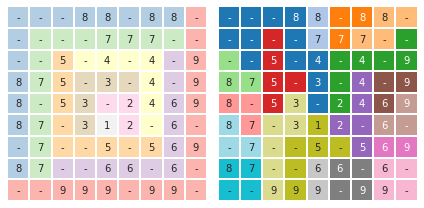

In [11]:
start = time.perf_counter()
test = Matrix(groups)
test.solve()
stop =  time.perf_counter()
print('Solution took {:0.4f} seconds'.format((stop-start)))

In [9]:
url='https://www.janestreet.com/puzzles/hooks-7-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:13]))))

### February 2021 : Solution

Here is the completed grid for this Hooks puzzle, which when you take
the product of the sizes of the empty regions gives
2200
.

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/20210228_hooks_7_ans-1.png" width="300" >